In [1]:
import numpy as np
from skimage import io,color
from scipy import signal,ndimage
from matplotlib import pyplot as plt
import queue
from scipy.ndimage import gaussian_filter
from PIL import Image
import glob
from numpy.lib.stride_tricks import as_strided

q = queue.SimpleQueue()

In [2]:
# Gaussian filter
def Gaussian(size, sigma): #5x5
    size = int(size) //2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normalization = 1/(2.0*np.pi*sigma**2)
    return np.exp(-((x**2+y**2))/2)*normalization

In [3]:
# Sobel filter
def sobel_filters(img):
    # sobel filter init
    sobel_x = np.array([[1, 0, -1],
                        [2, 0, -2],
                        [1, 0, -1]])
    sobel_y = sobel_x.ravel(order='F').reshape((3,3))

    
    ## sobel filtering
    sobel_x_img = signal.convolve2d(img,sobel_x, boundary = 'symm')
    sobel_y_img = signal.convolve2d(img,sobel_y, boundary = 'symm')
    
    sobel_img = np.sqrt(np.square(sobel_x_img) + np.square(sobel_y_img))
    sobel_img = sobel_img / sobel_img.max() * 255
    sobel_direc = np.arctan2(sobel_x_img, sobel_y_img)

#     print(sobel_img)
#     print(sobel_direc)
#     print('sobel_img', sobel_img.shape, '\nsobel_direc',sobel_direc.shape)

    return sobel_img,sobel_direc

In [28]:
# Non Maximum suppression
%time
def non_max_sup(box,direc):
    
    y_len, x_len = box.shape
    
    # return array
    keep = np.zeros((y_len-2)*(x_len-2))
    
    frame_1 = np.zeros((3,3))
    frame_2 = np.zeros(3)
        
    
    s = np.array([-np.pi, -np.pi*7/8, -np.pi*5/8, -np.pi*3/8, -np.pi/8, np.pi/8, np.pi*3/8, np.pi*5/8, np.pi*7/8, np.pi])
    
    sector = np.digitize(direc, s)
    sector[(sector == 1) | (sector == 5) | (sector == 9)] = 0
    sector[(sector == 2)| (sector == 6)] = 1
    sector[(sector == 3) | (sector == 7)] = 2
    sector[(sector == 4) | (sector == 8)] = 3

    sectoring = sector[1:-1,1:-1]
    sectoring = sectoring.flatten()
      
    expanded_input = as_strided(
        box,
        shape=(
            box.shape[0] - frame_1.shape[0] + 1,  # The feature map is a few pixels smaller than the input
            box.shape[1] - frame_1.shape[1] + 1,
            3,3
        ),
        strides=(
            box.strides[0],
            box.strides[1],
            box.strides[0],  # When we move one step in the 3rd dimension, we should move one step in the original data too
            box.strides[1],
        ),
        writeable=False,  # totally use this to avoid writing to memory in weird places
    )
    
    a = expanded_input.reshape((y_len-2)*(x_len-2),9)
    angle = np.array([  [False, True, False, False, True, False, False, True, False],
                        [True, False, False, False, True, False, False, False, True],
                        [False, False, False, True, True, True, False, False, False],
                        [False, False, True, False, True, False, True, False, False] ])
    
    a[np.where(sectoring == 0)] = a[np.where(sectoring == 0)]*angle[0]
    a[np.where(sectoring == 1)] = a[np.where(sectoring == 1)]*angle[1]
    a[np.where(sectoring == 2)] = a[np.where(sectoring == 2)]*angle[2]
    a[np.where(sectoring == 3)] = a[np.where(sectoring == 3)]*angle[3]
    
    max_position = np.argmax(a, axis=1).reshape((y_len-2)*(x_len-2),1)
    a[np.where(max_position != 4)[0],4] = a[np.where(max_position != 4)[0],4]*0
    
    keep = a[:,4].reshape(y_len-2,x_len-2)
            
    return keep

Wall time: 0 ns


In [29]:
# double threshold
def threshold(img, high_threshold, low_threshold, strong_pixel, weak_pixel):#strong, weak, non-relevant
    
    m,n=img.shape
    img[img>=high_threshold] = strong_pixel
    img[img<low_threshold] = 0
    return img

In [30]:
def replay(box, keep, max_var):
    
    y_len, x_len = box.shape
    
    frame = np.zeros((3, 3))
    
    while not q.empty():
        i,j = q.get()
        
        if box[i,j] != max_var :
            
            box[i,j] = max_var
            keep[i-1,j-1] = max_var
            
            frame[:] = box[i-1:i+2, j-1:j+2]
            
            for n in range(0,3):
                for m in range(0,3):
                    if frame[n,m] > 0 and frame[n,m] < max_var:
                        q.put((i+n-1,j+m-1))

In [7]:
def hysteresis(box, max_var):
    
    y_len, x_len = box.shape

    box_2 = np.zeros((y_len + 2, x_len + 2))
    box_2[1:-1, 1:-1] = box[:]
    
    keep = np.zeros((y_len,x_len))
    
    frame = np.zeros((3, 3))
    frame_2 = np.zeros(9)
    
    for i in range(0, y_len):
        for j in range(0, x_len):
            
            if box_2[i+1, j+1] == max_var :
                
                keep[i,j] = max_var
                
                frame = box_2[i:i+3, j:j+3]
                
                for n in range(0,3):
                    for m in range(0,3):
                        if frame[n,m] > 0 and frame[n,m] < max_var:
                            q.put((i+n,j+m))
            
            
                while not q.empty():
                    replay(box_2, keep, max_var)
                        
    return keep

In [20]:
def show_image(img):
    plt.figure(figsize=(8,16))
    if img.shape[0] == 3:
        img=img.transpose(1,2,0)
    plt.subplot(2,2,1)
    plt.imshow(img,cmap='gray')
    plt.show()

In [21]:
def Canny_detector(img):
    gaussian_size=5
    sigma = 5
    high_thres=50
    low_thres=30
    strong_pixel=255
    weak_pixel=100
    
    #sigma= int(input("Input sigma::"))
    #high_thres, low_thres = map(float, input("Input high_thres, low_threshold::").split())
    #print(sigma, high_thres, low_thres)
    
    smoothed_image1=signal.convolve2d(img,Gaussian(gaussian_size, sigma),mode='same',boundary = 'symm')
    
    gradient, theta=sobel_filters(smoothed_image1)
    nonMax_Img= non_max_sup(gradient, theta)
    # show_image(nonMax_Img)
    
    threshold_Img=threshold(nonMax_Img, high_thres, low_thres, strong_pixel, weak_pixel)    
    img_final=hysteresis(threshold_Img, strong_pixel)
    
    return img_final

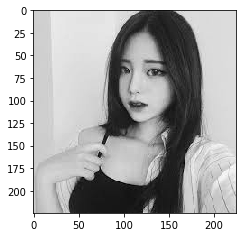

5 50 30
Time == 0.46


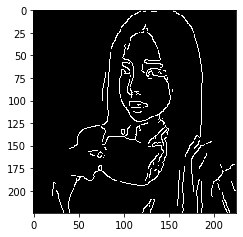

In [27]:
import time
import cv2 as cv
start=time.time()
test_img = 'data/model02.jpg'
img = io.imread(test_img,True)
show_image(img)
img=Canny_detector(img)

end = time.time()
print("Time == {:.2f}".format(end-start))
show_image(img)

In [ ]:
a=np.asarray([[1,2,3],[-1,-1,-1]])
b= np.array([[0,1,2],[2,3,1]])
a[ (b==1) 각도에 맞게 
  슬라이싱을 해서 그 3가지 값을 비교해서 그중 가장 크면 ] = 남겨
a

In [2]:
x=np.arange(10).reshape((2,5))
x

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [14]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)# 2+3,3
    print(a.shape[-1])# 5
    print(a.shape[:-1])# (2,)
    print(shape)# (2,3,3)
    
    strides = a.strides + (a.strides[-1],)
    
    print(a.strides)
    print((a.strides[-1],))
    print(strides)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

rolling_window(x,3)

5
(2,)
(2, 3, 3)
(20, 4)
(4,)
(20, 4, 4)


array([[[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4]],

       [[5, 6, 7],
        [6, 7, 8],
        [7, 8, 9]]])

In [63]:
import time
inputs = np.arange(10000).reshape(100, 100)
kernel = np.asarray([[0,0,0],
                    [0,1,0],
                    [0,0,0]])


feature_map = np.zeros(
   (inputs.shape[0] - kernel.shape[0] + 1,
    inputs.shape[1] - kernel.shape[1] + 1,
))

start=time.time()

for x in range(inputs.shape[0] - kernel.shape[0] + 1):
    for y in range(inputs.shape[1] - kernel.shape[1] + 1):
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                feature_map[x][y] += inputs[x + i][y + j] * kernel[i][j]
                
print("time == {}".format((time.time()-start)))
feature_map                

time == 0.2455148696899414


array([[ 101.,  102.,  103., ...,  196.,  197.,  198.],
       [ 201.,  202.,  203., ...,  296.,  297.,  298.],
       [ 301.,  302.,  303., ...,  396.,  397.,  398.],
       ...,
       [9601., 9602., 9603., ..., 9696., 9697., 9698.],
       [9701., 9702., 9703., ..., 9796., 9797., 9798.],
       [9801., 9802., 9803., ..., 9896., 9897., 9898.]])

In [65]:
from numpy.lib.stride_tricks import as_strided


input = np.arange(10000).reshape(100, 100)
kernel = np.asarray([[0,0,0],
                    [0,1,0],
                    [0,0,0]])

start=time.time()
expanded_input = as_strided(
    input,
    shape=(
        input.shape[0] - kernel.shape[0] + 1,  # The feature map is a few pixels smaller than the input
        input.shape[1] - kernel.shape[1] + 1,
        kernel.shape[0],
        kernel.shape[1],
    ),
    strides=(
        input.strides[0],
        input.strides[1],
        input.strides[0],  # When we move one step in the 3rd dimension, we should move one step in the original data too
        input.strides[1],
    ),
    writeable=False,  # totally use this to avoid writing to memory in weird places
)
#expanded_input

feature_map = np.einsum('xyij,ij->xy',expanded_input,kernel,)
print("time == {}".format((time.time()-start)))
print(feature_map)
#np.mean(expanded_input,-1)

time == 0.000997781753540039
[[ 101  102  103 ...  196  197  198]
 [ 201  202  203 ...  296  297  298]
 [ 301  302  303 ...  396  397  398]
 ...
 [9601 9602 9603 ... 9696 9697 9698]
 [9701 9702 9703 ... 9796 9797 9798]
 [9801 9802 9803 ... 9896 9897 9898]]
